# COVID-19 Documents Data Clustering with NMF

This jupyter notebook demonstrates document clustering with NMF topic modelling and generating tags from the clustered documents.

**About NMF**

- NMF : Non-Negative Matrix Factorization (NMF) is an unsupervised technique. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative. Using the original matrix (X), NMF will give you two matrices (W and H). W is the topics it found and H is the coefficients (weights) for those topics. In other words, X is articles by words (original), H is articles by topics and W is topics by words.


**Extracting features**
- We use TFIDF vectorizer instead of Count vectorizer for extracting features. 

**Parameters**
- We have chosen a value of Minimum DF equal to 20 to get rid of extremely rare words that appear in less than 20 documents, and a Maximum DF equal to 80%. 


In [38]:
import pandas as pd
from os.path import exists
import numpy as np
import itertools
import matplotlib.pyplot as plt
import re
import json
import nltk
import ast
import pickle
import datetime as dt
import operator
import pathlib
import timeit
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import decomposition
from sklearn.decomposition import NMF
from gensim.models import Word2Vec
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

In [2]:
INPUT_PATH = '../data/outputs/articles/'
OUTPUT_PATH = '../data/outputs/vector/'
MIN_DF =  20
MAX_DF = 0.8
NORM_FUNCTION = 'l1'
No_TOP_KEYOWRDS = 5

## Load preprocessed data

In [3]:
df = pd.read_csv(INPUT_PATH + "preprocessed_data(all_data_type).tsv", sep='\t', encoding='utf-8')
print(df.shape)

(413915, 73)


## Extract features 

In [4]:
def write_object(obj, output_fname):
    f = open(output_fname, 'wb')
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [5]:
def data_vectorization(weight, PATH, training_docs, _min_df, _max_df, norm_function):
    
    V_fname = PATH + "_V_{}.pkl".format(weight)
    D_fname = PATH + "_D_{}.pkl".format(weight)
    
    if exists(V_fname):
        print("File {} already exist".format(V_fname))
        V = pickle.load( open(V_fname, "rb") )
        D = pickle.load( open(D_fname, "rb") )
    else:
        if weight == 'tfidf':
            print('TfidfVectorizer is proceed')
            V = TfidfVectorizer(analyzer='word', min_df=_min_df, norm=norm_function, max_df=_max_df, encoding='utf-8') # Term Frequency times inverse document frequency.
            D = V.fit_transform(training_docs)
        else:
            print('CountVectorizer is proceed')
            V = CountVectorizer(analyzer='word', min_df=_min_df, max_df=_max_df, encoding='utf-8') 
            D = V.fit_transform(training_docs)

        # write the vectorizer and data
        write_object(V, V_fname)
        write_object(D, D_fname)

    return V, D

In [6]:
weight = "tfidf" # count or tfidf

corpus = list(df['text'])
print(len(corpus))
V, D = data_vectorization(weight, OUTPUT_PATH, corpus, MIN_DF, MAX_DF, NORM_FUNCTION)
print("Matrix shape:", D.shape)

413915
File ../data/outputs/vector/_V_tfidf.pkl already exist
Matrix shape: (413915, 24019)


## Find the optimal topic size by coherence means 

In [7]:
w2v_model = Word2Vec.load('../data/covid_word2vec/covid_100d.model')

In [8]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if w2v_model.wv.__contains__(pair[0]) and w2v_model.wv.__contains__(pair[1]):
                similarity = w2v_model.wv.similarity(pair[0], pair[1])
                pair_scores.append(max(0, similarity)) # return positive value
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


In [9]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [10]:
def get_coherence(V, D, w2v_model, No_TOP_KEYOWRDS):

    kmin, kmax = 3, 30
    
    topic_models = []
    k_values = []
    coherences = []
    # try each value of k
    for k in range(kmin,kmax+1):
        # run NMF
        model = decomposition.NMF( init="nndsvd", n_components=k, random_state=1, max_iter=800) # 'nndsvd' works best for sparse data where the most of value are 0
        W = model.fit_transform( D ) # fit vectorization results
        H = model.components_    
        # store for later
        topic_models.append( (k,W,H) )
        # Get top-n topic descriptors 
        term_rankings = []
        for topic_index in range(k):
            term_rankings.append( get_descriptor( V.get_feature_names(), H, topic_index, No_TOP_KEYOWRDS ) )
        # Now calculate the coherence based on our Word2vec model
        k_values.append( k )
        coherences.append( calculate_coherence( w2v_model, term_rankings ) )
        print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )
   
    return k_values, coherences

In [14]:
No_TOP_KEYOWRDS = 5
k_values, coherences = get_coherence(V, D, w2v_model, No_TOP_KEYOWRDS)

K=03: Coherence=0.4818
K=04: Coherence=0.4436
K=05: Coherence=0.4139
K=06: Coherence=0.4290
K=07: Coherence=0.4211
K=08: Coherence=0.4540
K=09: Coherence=0.4365
K=10: Coherence=0.4505
K=11: Coherence=0.4562
K=12: Coherence=0.4434
K=13: Coherence=0.4498
K=14: Coherence=0.4590
K=15: Coherence=0.4395
K=16: Coherence=0.4451
K=17: Coherence=0.4414
K=18: Coherence=0.4555
K=19: Coherence=0.4523
K=20: Coherence=0.4703
K=21: Coherence=0.4457
K=22: Coherence=0.4593
K=23: Coherence=0.4565
K=24: Coherence=0.4505
K=25: Coherence=0.4420
K=26: Coherence=0.4518
K=27: Coherence=0.4548
K=28: Coherence=0.4598
K=29: Coherence=0.4596
K=30: Coherence=0.4524


In [15]:
def show_coherence(k_values, coherences, No_TOP_KEYOWRDS):
    fig = plt.figure(figsize=(12,8))
    # create the line plot
    ax = plt.plot( k_values, coherences )
    #plt.title('Coherence Mean with {} top keywords'.format(No_TOP_KEYOWRDS))
    plt.title('Coherence Mean')
    plt.xticks(k_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Mean Coherence")
    plt.grid()
    # add the points
    plt.scatter( k_values, coherences, s=36)
    # find and annotate the maximum point on the plot
    """
    ymax = max(coherences)
    xpos = coherences.index(ymax)
    best_k = k_values[xpos]
    plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
    """
    plt.savefig('../img/coherence_top{}keywords.pdf'.format(No_TOP_KEYOWRDS), format='pdf', bbox_inches='tight') 
    # show the plot
    plt.show()

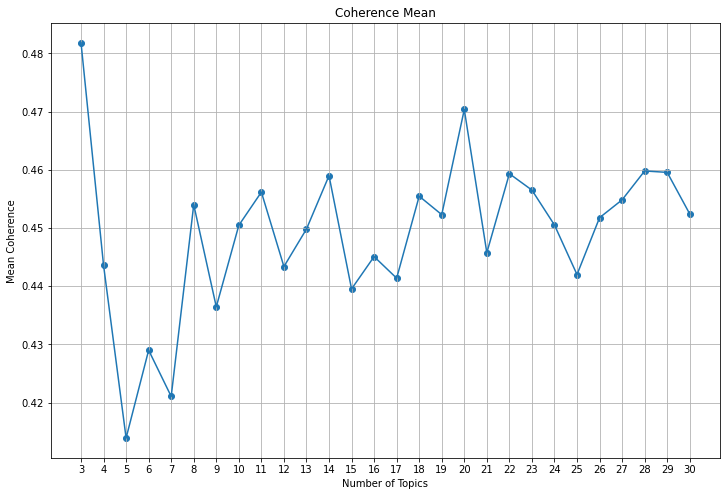

In [16]:
show_coherence(k_values, coherences, No_TOP_KEYOWRDS)

## Apply topic modelling

In [7]:
k = 12
NMF_model = NMF(n_components=k, init='nndsvd', random_state=1).fit(D)
H = NMF_model.transform(D) # articles by topic
W = NMF_model.components_  # topics by words.

In [8]:
# identify first and second topic for each article

top2_collections_df = pd.DataFrame()
top2_collections_df['_id'] = df['_id']

top_1_collection_list=[]
top_2_collection_list=[]
top_1_collection_weight_list=[]
top_2_collection_weight_list=[]

for a in H:
    top_2_idx = np.argsort(a)[-2:]
    top_2_values = [a[i] for i in top_2_idx]
    top_1_collection_list.append(str(top_2_idx[1]))
    top_2_collection_list.append(str(top_2_idx[0]))
    top_1_collection_weight_list.append(round(top_2_values[1], 5))
    top_2_collection_weight_list.append(round(top_2_values[0], 5))
    
top2_collections_df['top1_collection'] = top_1_collection_list
top2_collections_df['top2_collection'] = top_2_collection_list
top2_collections_df['top1_collection_weight'] = top_1_collection_weight_list
top2_collections_df['top2_collection_weight'] = top_2_collection_weight_list

In [9]:
OUT_PATH = '../data/outputs/topic_modelling_results/'
top2_collections_df.to_csv(OUT_PATH+"top2_collections_by_article.csv", index=False)

# Explore topic modelling results

## Print collection keywords 

In [10]:
def get_top_keywords(model, optimal_topic_size, n_top_words, V):
    
    feat_names = V.get_feature_names()
    
    word_dict = {};
    for i in range(optimal_topic_size):
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Collection # ' + '{:02d}'.format(i)] = words;
    
    return pd.DataFrame(word_dict);

In [11]:
OUTPUT_PATH = '../data/outputs/topic_modelling_results/'

In [12]:
No_TOP_KEYOWRDS = 10
pd.set_option('display.max_columns', None)
# print top-n keywords for the topics
nmf_df = get_top_keywords(NMF_model, k, No_TOP_KEYOWRDS, V)
nmf_df.to_csv(OUTPUT_PATH+"{}Keywords_in_{}_collections.csv".format(No_TOP_KEYOWRDS, k), sep=',', encoding='utf-8', index=False)
nmf_df

,Collection # 00,Collection # 01,Collection # 02,Collection # 03,Collection # 04,Collection # 05,Collection # 06,Collection # 07,Collection # 08,Collection # 09,Collection # 10,Collection # 11
0,pandemic,patient,student,vaccine,disease,impact,health,review,infection,child,cancer,syndrome
1,surgery,clinical,time,vaccination,cardiovascular,lockdown,mental,systematic,risk,adolescent,treatment,acute
2,management,outcome,response,mrna,novel,economy,care,meta_analysis,asymptomatic,parent,care,respiratory
3,challenge,mortality,study,hesitancy,severity,psychological,worker,literature,cell,multisystem,breast,severe
4,lesson,hospitalized,learning,variant,treatment,economic,public,treatment,control,inflammatory,lung,case
5,experience,critically,model,development,chronic,india,healthcare,peer,human,clinical,management,east
6,telemedicine,pneumonia,case,antibody,management,market,among,manifestation,antibody,young,surgery,middle
7,care,care,education,safety,kidney,global,service,narrative,case,school,colorectal,distress
8,practice,characteristic,analysis,efficacy,rheumatic,industry,professional,clinical,prevention,family,diagnosis,pneumonia
9,global,risk,online,trial,infectious,sector,system,novel,pregnancy,effect,vaccination,protein


### Top topic keywords' weights

In [14]:
def get_top_keyword_weights(model, optimal_topic_size, n_top_words, V):
    
    feat_names = V.get_feature_names()
    
    word_dict = {};
    for i in range(optimal_topic_size):
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Collection # ' + '{:02d}'.format(i)] = words;
    
    return pd.DataFrame(word_dict);

In [15]:
def print_top_keyword_weights(model, optimal_topic_size, n_top_words, V):
    feature_names = V.get_feature_names()
    fig, axes = plt.subplots(3, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        #print(top_features)
        #print(weights)
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Collection# {topic_idx}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        #fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

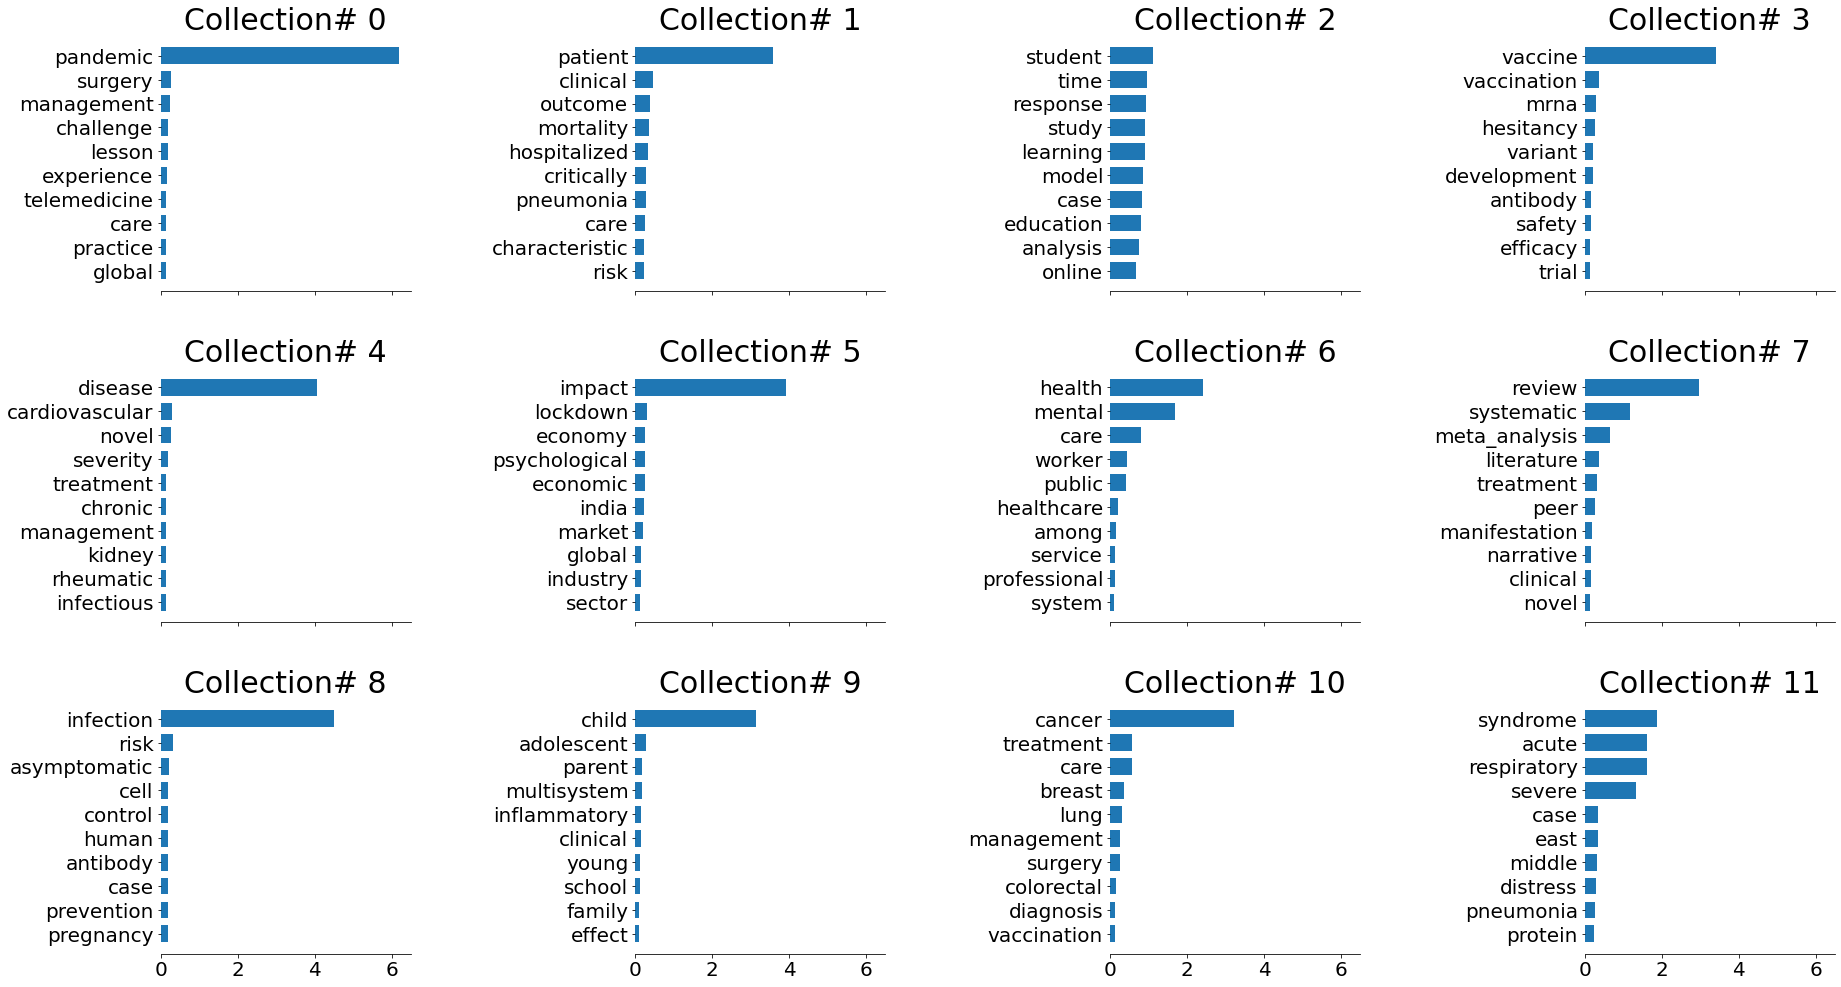

In [16]:
print_top_keyword_weights(NMF_model, k, No_TOP_KEYOWRDS, V)

## Name the collections 

- Collection#0: Pandemic impact (High confidence)
- Collection#1: Comorbidity (High Confidence)
- Collection#2: Lifestyle and education impact (Medium Confidence)
- Collection#3: Vaccine(High Confidence)
- Collection#4: Public Health (Low C)
- Collection#5: Socio-economic impact (High C)
- Collection#6: Health care management (Medium C)
- Collection#7: Literature and meta analysis (High C)
- Collection#8: Infection (High C)
- Collection#9: Children and adolescent (High C)
- Collection#10: Cancer Treatment (High C)
- Collection#11: Epidemiology (Low C)

## Print collection distributions

In [13]:
# count articles in collections

top1_collection_counter = {}
top2_collection_counter = {}
for index, row in top2_collections_df.iterrows():
    col1 = row['top1_collection']
    col2 = row['top2_collection']
    if '# ' + '{:02d}'.format(int(col1)) not in top1_collection_counter.keys():
        top1_collection_counter['# ' + '{:02d}'.format(int(col1))] = 1
    else:
        top1_collection_counter['# ' + '{:02d}'.format(int(col1))] += 1
    if '# ' + '{:02d}'.format(int(col2)) not in top2_collection_counter.keys():
        top2_collection_counter['# ' + '{:02d}'.format(int(col2))] = 1
    else:
        top2_collection_counter['# ' + '{:02d}'.format(int(col2))] += 1

In [14]:
# sort dictionary by key (collection number)
top1_num_of_articles = []
top2_num_of_articles = []
for key in sorted(top1_collection_counter):
    top1_num_of_articles.append(top1_collection_counter[key])
    top2_num_of_articles.append(top2_collection_counter[key])

In [15]:
def show_distribution(unique, top1_num_of_articles, top2_num_of_articles):
    plt.figure(figsize=(12, 6))

    plt.bar(unique, top1_num_of_articles, label='Articles with the highest topic weights')
    plt.bar(unique, top2_num_of_articles, label='Articles with the second highest topic weights', bottom=top1_num_of_articles)
    plt.yticks(fontsize=14)
    plt.xticks(unique, unique)
    plt.ylabel('Number of research articles', fontweight='bold', fontsize=14)
    plt.xlabel('Collection#', fontweight='bold', fontsize=14)
    
    for index, value in enumerate(top1_num_of_articles):
        plt.text(index-0.4, top1_num_of_articles[index] + top2_num_of_articles[index], top1_num_of_articles[index] + top2_num_of_articles[index], fontsize=12)
    plt.legend()
    #plt.grid(True, axis='y')
    plt.savefig('../img/Topic_distribution.pdf', format='pdf', bbox_inches='tight')  
    plt.show()

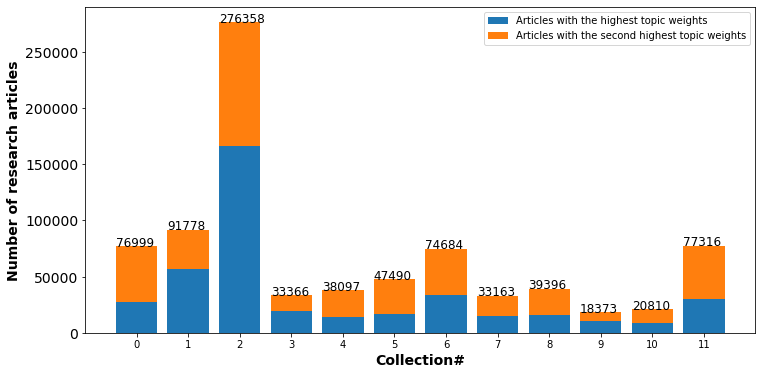

In [20]:
# show number of articles
# blue = top1 collection
# orange = top2 collection

unique = range(k)
show_distribution(unique, top1_num_of_articles, top2_num_of_articles)

## Article co-occurrence 

In [18]:
# Identify Sum of x and number of x

c_pair_x_num = {} # coumt number of x
c_pair_x_sum = {} # sum of x
for index, row in top2_collections_df.iterrows():
    c_pair = (row['top1_collection'], row['top2_collection'])
    if c_pair not in c_pair_x_num.keys():
        c_pair_x_num[c_pair] = 1
    else:
        c_pair_x_num[c_pair] += 1

In [24]:

co_oc_df = pd.DataFrame(columns=['collection1', 'collection2', '# articles'])
for i in range(k):
    for j in range(k):
        if i == j:continue
        co_oc_df = co_oc_df.append({
            "collection1":str(i),
            "collection2":str(j),
            "# articles":str(c_pair_x_num[(str(i), str(j))] + c_pair_x_num[(str(j), str(i))])}, ignore_index=True)
co_oc_df.to_csv(OUTPUT_PATH + "co-occurrence_articles_btw_collections.csv", index=False)

In [28]:
# convert DF to matrix format

matrix_df = pd.DataFrame()
for c1 in range(k):
    placeholders = []
    for c2 in range(k):
        placeholders.append(0)
    matrix_df[c1] = placeholders
    
for index, row in co_oc_df.iterrows():
    collection1 = int(str(row['collection1']).replace('.0', ''))
    collection2 = int(str(row['collection2']).replace('.0', ''))
    # calculate co-occurrence rate: number of article co-occurrend/number of articles in two collections
    cooccurrence = row['# articles']
    num_articles_in_first_collection = len(top2_collections_df.loc[top2_collections_df['top1_collection'] == str(collection1)])
    num_articles_in_second_collection = len(top2_collections_df.loc[top2_collections_df['top1_collection'] == str(collection2)])
    co_rate = round(int(cooccurrence)/(num_articles_in_first_collection + num_articles_in_second_collection), 3)
    matrix_df[collection2].iloc[collection1] = co_rate

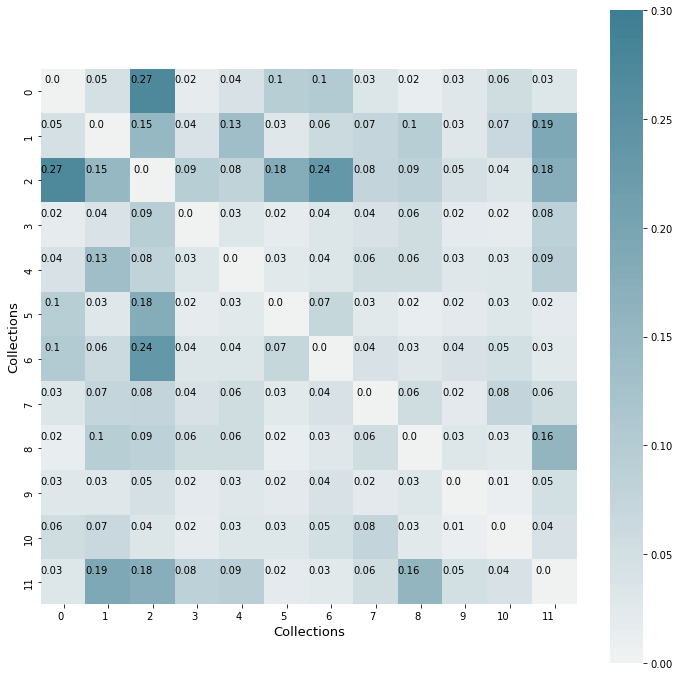

In [29]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,12))         
ax = sns.heatmap(
    matrix_df, 
    vmin=0, vmax=0.3, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    horizontalalignment='right'
);
j = 12
for c in matrix_df.columns:
    i = 0
    for index, row in matrix_df.iterrows():
        value = row[c]
        ax.text(i/12+0.02, j/12-0.02, round(value, 2), horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes)
        i += 1
    j -= 1
plt.xlabel('Collections', fontsize = 13) 
plt.ylabel('Collections', fontsize = 13) 

plt.savefig('../img/co-occurrence.pdf', format='pdf', bbox_inches='tight')

**How the co-occurrence rate calculated?**

The co-occurrence rate between collection#0 and collection#1 : 
The number of articles which top1 and top2 collections are collection#0 and collection#1 divided by 
the umber of articles with top1 collection is collection#0 + Number of articles with top1 collection is collection#1

## AVG topic weights collections

In [31]:
topic_w_list = []
for c in range(k):
    sub_df1 = top2_collections_df['top1_collection_weight'].loc[top2_collections_df['top1_collection'] == '{}'.format(c)]
    sub_df2 = top2_collections_df['top2_collection_weight'].loc[top2_collections_df['top2_collection'] == '{}'.format(c)]

    total_weight = 0
    for a in sub_df1:
        total_weight += a
    for a in sub_df2:
        total_weight += a 
    topic_w_list.append(round(total_weight/(len(sub_df1) + len(sub_df2)), 4))

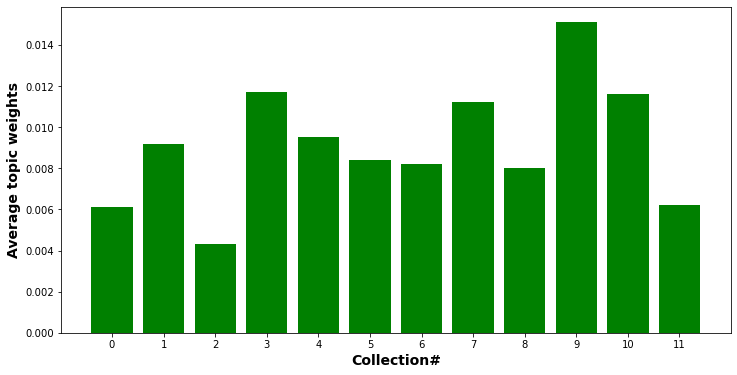

In [32]:
plt.figure(figsize=(12, 6))
plt.bar(unique, topic_w_list, color='green')
#plt.yticks(fontsize=14)
plt.xticks(unique, unique)
plt.ylabel('Average topic weights', fontweight='bold', fontsize=14)
plt.xlabel('Collection#', fontweight='bold', fontsize=14)

plt.show()

# Save result

## Add full topic modelling results to the DF

In [34]:
topic_name = {}
topic_name[0] = 'Pandemic impact'
topic_name[1] = 'Comorbidity'
topic_name[2] = 'Lifestyle and education impact'
topic_name[3] = 'Vaccine'
topic_name[4] = 'Public health'
topic_name[5] = 'Socio-economic impact'
topic_name[6] = 'Health care management'
topic_name[7] = 'Literature and meta analysis'
topic_name[8] = 'Infection'
topic_name[9] = 'Children and adolescent'
topic_name[10] = 'Cancer treatment'
topic_name[11] = 'Epidemiology'

In [35]:
max_topic_list = []
topic_weights_list = []
for weights in H:
    top_idx = np.argsort(weights)[-1:]
    max_topic_num = top_idx[0] # max topic number
    max_topic_list.append(topic_name[max_topic_num]) # max topic number's name
    weight_dictionary = {}
    for i in range(len(weights)):
        weight_dictionary[topic_name[i]] = round(weights[i], 5)
    topic_weights_list.append(weight_dictionary) # save topic weights

In [36]:
# create new columns and save the results

df['Research Topic'] = max_topic_list
df['Topic correlation'] = topic_weights_list

In [39]:
df.head()

,_id,abstract,URL,member,score,created,update-policy,license,ISSN,container-title,issued,prefix,reference-count,indexed,author,DOI,is-referenced-by-count,published,published-print,alternative-id,subject,published-online,content-domain,reference,title,link,source,type,publisher,volume,references-count,issn-type,deposited,page,short-container-title,import-source,last-updated,issue,journal-issue,published-other,funder,assertion,posted,subtype,accepted,group-title,institution,editor,original-title,subtitle,archive,relation,article-number,event,update-to,clinical-trial-number,isbn-type,ISBN,edition-number,publisher-location,chair,degree,approved,translator,pubmed-abstract,content-created,description,review,standards-body,content-updated,short-title,language,text,Research Topic,Topic correlation
0,10.1177/20503121211027778,<jats:sec><jats:title>Objective:</jats:title><...,http://dx.doi.org/10.1177/20503121211027778,179.0,0,"{'date-parts': [[2021, 6, 30]], 'date-time': '...",http://dx.doi.org/10.1177/sage-journals-update...,"[{'start': {'date-parts': [[2021, 1, 1]], 'dat...","['2050-3121', '2050-3121']",['SAGE Open Medicine'],"{'date-parts': [[2021, 1]]}",10.1177,16,"{'date-parts': [[2022, 2, 25]], 'date-time': '...",[{'ORCID': 'http://orcid.org/0000-0003-0697-91...,10.1177/20503121211027778,2,"{'date-parts': [[2021, 1]]}","{'date-parts': [[2021, 1]]}",['10.1177/20503121211027778'],['General Medicine'],"{'date-parts': [[2021, 6, 30]]}","{'domain': ['journals.sagepub.com'], 'crossmar...","[{'key': 'bibr1-20503121211027778', 'doi-asser...",['COVID-19 and dysnatremia: A comparison betwe...,[{'URL': 'http://journals.sagepub.com/doi/pdf/...,Crossref,journal-article,SAGE Publications,9,16,"[{'value': '2050-3121', 'type': 'print'}, {'va...","{'date-parts': [[2021, 6, 30]], 'date-time': '...",205031212110277,['SAGE Open Medicine'],crossref_all_json.tar.gz,{'$date': '2022-03-13T05:16:23.776Z'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,dysnatremia comparison respiratory illness inv...,Comorbidity,"{'Pandemic impact': 0.0, 'Comorbidity': 0.0172..."
1,10.1093/ofid/ofaa439.692,<jats:title>Abstract</jats:title>\n ...,http://dx.doi.org/10.1093/ofid/ofaa439.692,286.0,0,"{'date-parts': [[2021, 1, 2]], 'date-time': '2...",NaN,"[{'start': {'date-parts': [[2021, 1, 2]], 'dat...",['2328-8957'],['Open Forum Infectious Diseases'],"{'date-parts': [[2020, 10, 1]]}",10.1093,0,"{'date-parts': [[2021, 12, 14]], 'date-time': ...","[{'given': 'Minji', 'family': 'Kang', 'sequenc...",10.1093/ofid/ofaa439.692,0,"{'date-parts': [[2020, 10, 1]]}","{'date-parts': [[2020, 12, 31]]}",NaN,"['Infectious Diseases', 'Oncology']","{'date-parts': [[2020, 12, 31]]}","{'domain': [], 'crossmark-restriction': False}",NaN,['499. Infection with Coronavirus Disease 19 (...,[{'URL': 'http://academic.oup.com/ofid/article...,Crossref,journal-article,Oxford University Press (OUP),7,0,"[{'value': '2328-8957', 'type': 'electronic'}]","{'date-parts': [[2021, 1, 2]], 'date-time': '2...",S315-S315,NaN,crossref_all_json.tar.gz,{'$date': '2022-03-13T07:18:42.554Z'},Supplement_1,"{'issue': 'Supplement_1', 'published-print': {...","{'date-parts': [[2020, 10, 1]]}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,infection disease healthcare personnel exposur...,Lifestyle and education impact,"{'Pandemic impact': 1e-05, 'Comorbidity': 0.00..."
2,10.3390/vaccines9050490,"<jats:p>(1) Background: By April 2021, over 16...",http://dx.doi.org/10.3390/vaccines9050490,1968.0,0,"{'date-parts': [[2021, 5, 12]], 'date-time': '...",NaN,"[{'start': {'date-parts': [[2021, 5, 11]], 'da...",['2076-393X'],['Vaccines'],"{'date-parts': [[2021, 5, 11]]}",10.3390,38,"{'date-parts': [[2021, 12, 12]], 'date-time': ...","[{'given': 'Lu', 'family': 'Li', 'sequence': '...",10.3390/vaccines9050490,3,"{'date-parts': [[2021, 5, 11]]}",NaN,['vaccines9050

In [23]:
OUTPUT_PATH = '../data/outputs/topic_modelling_results/'
new_df = df.drop(columns=['text'], inplace=False)
result_json = new_df.to_json(orient="records")
with open(OUTPUT_PATH+'covid_articles_topic_modelling_results.json', 'w') as outfile:
    outfile.write(result_json)

# Wordcloud

We create wordcloud for each collection based on word frequency of top 1 collection articles (Exclude articles matched with top2 collection). 

In [151]:
import random 

def getRandomCol():
    r = random.randrange(30, 180)
    g = random.randrange(30, 180)
    b = random.randrange(30, 180)
    return (r, g, b)

def show_wordcloud(df):
    topics = list(set(df['Research Topic']))
    i = 0
    fig = plt.figure(figsize=(14,6))
    for t in topics:
        ax = fig.add_subplot(3,4,i+1)
        topic_df = df.loc[df['Research Topic'] == '{}'.format(t)]
        text = ''
        for index, row in topic_df.iterrows():
            text += row['text']
        wordcloud = WordCloud(background_color="white", collocations=False).generate(str(text))
        plt.title("{}".format(t))
        colour = getRandomCol()
        ax.imshow(wordcloud.recolor(color_func=lambda *args, **kwargs: colour))
        ax.axis('off')
        i += 1
    plt.tight_layout()
    plt.savefig('../img/wordcloud.pdf', format='pdf', bbox_inches='tight')
    plt.show()

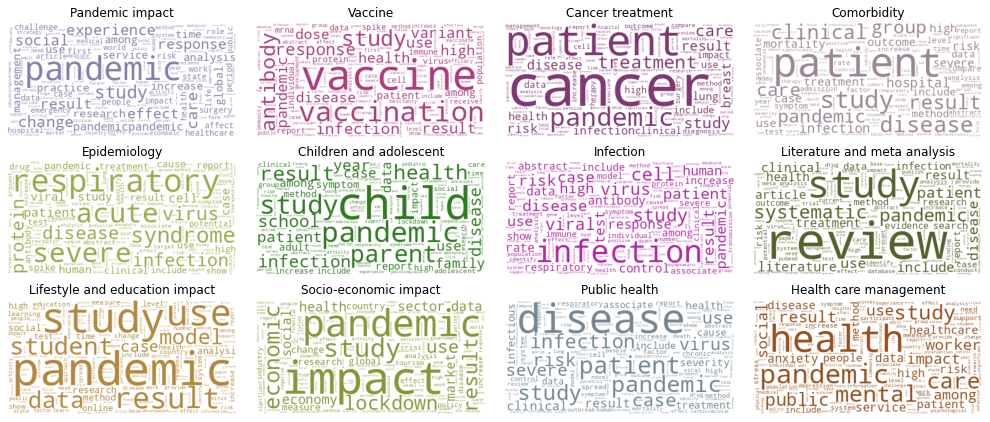

In [153]:
show_wordcloud(df)

# Trend of collections over time

In [155]:
def cleaning_text(date):
    row_value = ast.literal_eval(date)
    year = row_value['date-parts'][0][0]
    month = row_value['date-parts'][0][1]
    day = 1
    return "{}/{}/{}".format(month, day, year)

In [ ]:
text_cleaning = lambda x: cleaning_text(x)
df['date'] = df['created'].apply(text_cleaning)
df['date'] = pd.to_datetime(df['date']).dt.to_period('M')
sorted_df = df.sort_values(by=['date'], inplace=False) # sort by date

In [157]:
# Only use top1 collection

sub_df = sorted_df[['_id', 'Research Topic', 'date']]
sub_df

,_id,Research Topic,date
366510,10.1016/s0168-1702(01)00228-3,Lifestyle and education impact,2002-07
380262,10.1128/jvi.74.7.3379-3387.2000,Epidemiology,2002-07
352698,10.1128/jvi.74.19.9062-9070.2000,Lifestyle and education impact,2002-07
368340,10.1016/s0165-2427(96)05702-9,Infection,2002-07
353467,10.1016/0014-5793(78)80935-1,Lifestyle and education impact,2002-07
...,...,...,...
51789,10.21203/rs.3.rs-1401256/v1,Public health,2022-02
121173,10.1186/s12992-022-00802-y,Health care management,2022-02
51768,10.31234/osf.io/v8tdf,Lifestyle and education impact,2022-02
51753,10.31219/osf.io/qbg45,Public health,2022-02


In [159]:
groupby_sub_df = sub_df.groupby(['date', 'Research Topic'])["_id"].count().reset_index(name="count")

In [161]:
# convert pivot table, thus each topic become column where value indicate number of document
table = pd.pivot_table(groupby_sub_df, values='count', index=['date'],
                    columns=['Research Topic'], aggfunc=np.sum, fill_value=0)

table = table.reindex(sorted(table.columns), axis=1)
#OUTPUT_PATH = '../data/outputs/topic_modelling_results/'
#table.to_csv(OUTPUT_PATH + 'collections_by_month.csv', sep=',', encoding='utf-8')
table

Research Topic,Cancer treatment,Children and adolescent,Comorbidity,Epidemiology,Health care management,Infection,Lifestyle and education impact,Literature and meta analysis,Pandemic impact,Public health,Socio-economic impact,Vaccine
date,,,,,,,,,,,,
2002-07,0,0,2,51,0,20,52,1,0,1,0,8
2002-09,0,0,0,0,0,1,0,0,0,0,0,0
2002-10,0,0,0,14,0,5,11,0,0,0,0,1
2002-11,0,0,0,1,0,1,0,0,0,0,0,1
2002-12,0,0,1,33,0,18,45,0,0,5,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10,402,573,2813,1038,1815,729,7841,706,1304,520,791,1218
2021-11,287,570,2675,994,1519,653,8003,572,1245,415,839,1193
2021-12,304,587,2633,1070,1885,667,9250,625,1276,479,829,1531


In [162]:
# convert table where values are cumulative
cum_table = table.cumsum(axis=0)
#cum_table.to_csv(OUTPUT_PATH + 'collections_by_month(cum).csv', sep=',', encoding='utf-8')
cum_table

Research Topic,Cancer treatment,Children and adolescent,Comorbidity,Epidemiology,Health care management,Infection,Lifestyle and education impact,Literature and meta analysis,Pandemic impact,Public health,Socio-economic impact,Vaccine
date,,,,,,,,,,,,
2002-07,0,0,2,51,0,20,52,1,0,1,0,8
2002-09,0,0,2,51,0,21,52,1,0,1,0,8
2002-10,0,0,2,65,0,26,63,1,0,1,0,9
2002-11,0,0,2,66,0,27,63,1,0,1,0,10
2002-12,0,0,3,99,0,45,108,1,0,6,0,16
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10,7310,7860,46707,26404,26711,13427,132466,12596,22726,12620,13859,13602
2021-11,7597,8430,49382,27398,28230,14080,140469,13168,23971,13035,14698,14795
2021-12,7901,9017,52015,28468,30115,14747,149719,13793,25247,13514,15527,16326


In [169]:
rank_cum_table = pd.DataFrame(columns=list(cum_table.columns))
i = 0
for index, row in cum_table.iterrows():
    l = cum_table.iloc[i]
    result = [sorted(l, reverse=True).index(x)+1 for x in l]
    rank_cum_table.loc[i] = result
    i += 1
    
rank_cum_table.index= cum_table.index
rank_cum_table.to_csv(OUTPUT_PATH + 'collections_by_month(rank).csv', sep=',', encoding='utf-8')
rank_cum_table

,Cancer treatment,Children and adolescent,Comorbidity,Epidemiology,Health care management,Infection,Lifestyle and education impact,Literature and meta analysis,Pandemic impact,Public health,Socio-economic impact,Vaccine
date,,,,,,,,,,,,
2002-07,8,8,5,2,8,3,1,6,8,6,8,4
2002-09,8,8,5,2,8,3,1,6,8,6,8,4
2002-10,8,8,5,1,8,3,2,6,8,6,8,4
2002-11,8,8,5,1,8,3,2,6,8,6,8,4
2002-12,8,8,6,2,8,3,1,7,8,5,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10,12,11,2,4,3,8,1,10,5,9,6,7
2021-11,12,11,2,4,3,8,1,9,5,10,7,6
2021-12,12,11,2,4,3,8,1,9,5,10,7,6


In [38]:
import pandas as pd

OUTPUT_PATH = '../data/outputs/topic_modelling_results/'
rank_cum_table = pd.read_csv(OUTPUT_PATH + 'collections_by_month(rank).csv', index_col=0)

In [50]:
def bumpchart(df, selected_collections, show_rank_axis= True, rank_axis_distance= 1.1, 
              ax= None, scatter= False, holes= False,
              line_args= {}, scatter_args= {}, hole_args= {}):
    
    fig = plt.figure(figsize=(9,5))
    if ax is None:
        left_yaxis= plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()
    
    axes = [left_yaxis, right_yaxis]
    
    # Creating the far right axis if show_rank_axis is True
    if show_rank_axis:
        far_right_yaxis = left_yaxis.twinx()
        axes.append(far_right_yaxis)
    flag = 0
    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes 
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha= 0)
            
        if col not in selected_collections:
            left_yaxis.plot(x, y, **line_args, solid_capstyle='round', color='grey', alpha=0.1)
            
            # Adding scatter plots
            if scatter:
                left_yaxis.scatter(x, y, **scatter_args, color='green', alpha=0.1)
                
                #Adding see-through holes
                if holes:
                    bg_color = left_yaxis.get_facecolor()
                    left_yaxis.scatter(x, y, color= bg_color, **hole_args)
        else: # highlight selected values
            if flag != 1: c = 'red'
            else: c='blue'
            left_yaxis.plot(x, y, **line_args, solid_capstyle='round', color=c, label=col)
            left_yaxis.legend(loc='upper right')
            left_yaxis.set_xlabel("Date")
            left_yaxis.set_ylabel("Rank")
            # Adding scatter plots
            if scatter:
                left_yaxis.scatter(x, y, **scatter_args, color=c)

                #Adding see-through holes
                if holes:
                    bg_color = left_yaxis.get_facecolor()
                    left_yaxis.scatter(x, y, color= bg_color, **hole_args)
            flag = 1
    # Number of lines
    lines = len(df.columns)
    y_ticks = [*range(1, lines + 1)]
    
    x_ticks = []
    for j in range(1, len(df.index)+1, 12):
        x_ticks.append(rank_cum_table.index[j])
    
    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))
    
    # Sorting the labels to match the ranks.
    left_labels = df.iloc[0].sort_values().index
    right_labels = df.iloc[-1].sort_values().index
    
    axis.xaxis.set_major_locator(plt.MaxNLocator(12))
    
    return axes

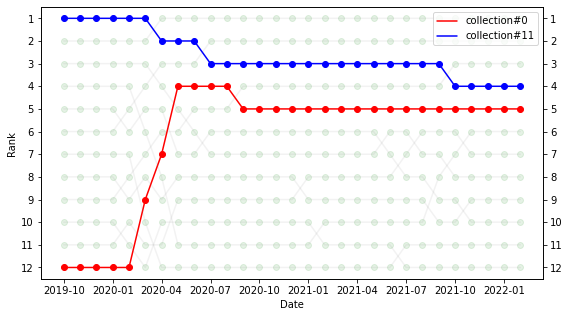

In [63]:
last_month = 29
selected_collections = ['collection#0', 'collection#11']
bumpchart(rank_cum_table.tail(last_month), selected_collections, show_rank_axis= False, scatter=True)

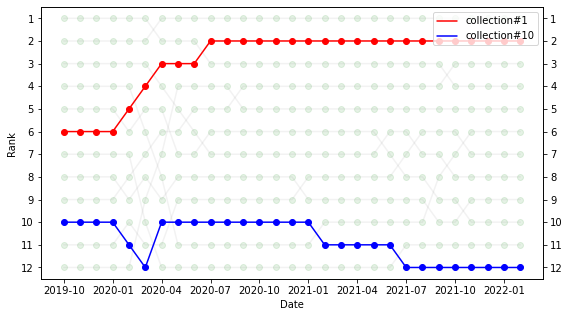

In [64]:
selected_collections = ['collection#1', 'collection#10']
bumpchart(rank_cum_table.tail(last_month), selected_collections, show_rank_axis= False, scatter=True)

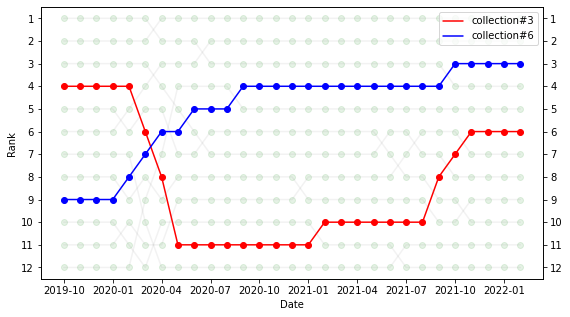

In [65]:
selected_collections = ['collection#3', 'collection#6']
bumpchart(rank_cum_table.tail(last_month), selected_collections, show_rank_axis= False, scatter=True)

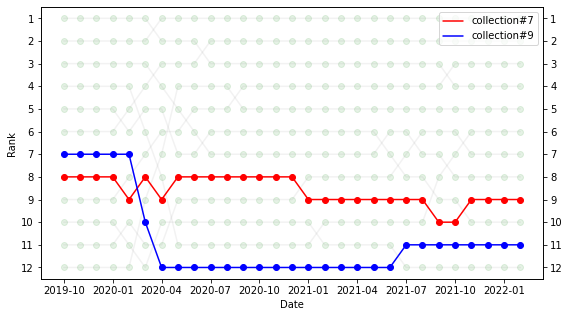

In [66]:
selected_collections = ['collection#7', 'collection#9']
bumpchart(rank_cum_table.tail(last_month), selected_collections, show_rank_axis= False, scatter=True)

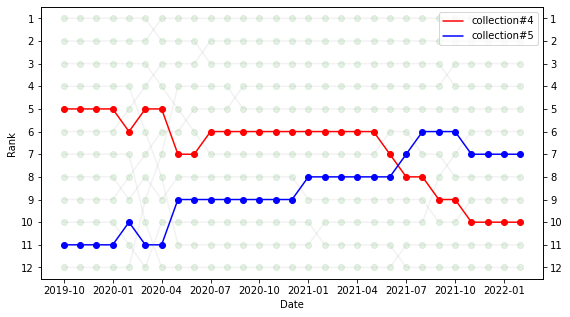

In [68]:
selected_collections = ['collection#4', 'collection#5']
bumpchart(rank_cum_table.tail(last_month), selected_collections, show_rank_axis= False, scatter=True)

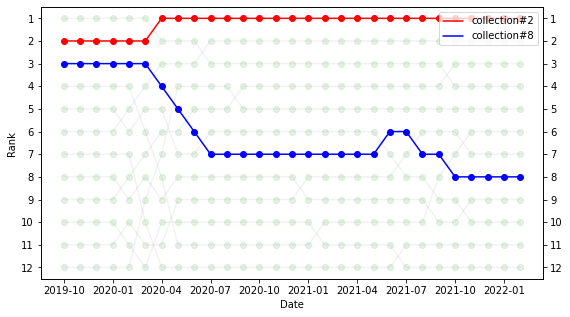

In [69]:
selected_collections = ['collection#2', 'collection#8']
bumpchart(rank_cum_table.tail(last_month), selected_collections, show_rank_axis= False, scatter=True)